In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras.layers import Input, Lambda, Dense, Flatten,Dropout
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from matplotlib.pyplot import figure
plt.style.use('ggplot')

In [4]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.3)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [5]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [6]:
def initiateModel(noOfClasses,dropout):
    modelInput = tf.keras.applications.efficientnet.EfficientNetB0(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    x=Dense(32,activation='relu')(x)
    x=Dropout(dropout)(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [7]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'VGG16.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint


In [8]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 16):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      #callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [9]:
def plotOutput(history, className, epochs):
    figure(figsize=(10, 7), dpi=80)
    # plt.plot([1, 0], [0, 1], 'k--')
    plt.plot(history.history['accuracy'],label='Training_accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation_accuracy')
    plt.plot(history.history['loss'],label='Training_loss')
    plt.plot(history.history['val_loss'],label='Validation_loss')
    plt.legend()
    plt.title('Training Accuracy vs Validation Accuracy & Training Loss vs Validation Loss')
    plt.xlabel('No.of epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Np.of epochs')
    plt.ylabel('Loss')
    plt.show()

In [10]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - VGG16.h5")
    print("Model Saved!")

In [11]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [12]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [13]:
mpath = r'/content/drive/MyDrive/Lung and Colon'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 50
lr = 0.0001

for i in classPaths:
    print(i)
    

Dataset
code



Total :  Found 8102 files belonging to 5 classes.

For Training :  Found 5673 images belonging to 5 classes.

For Val :  Found 2429 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)


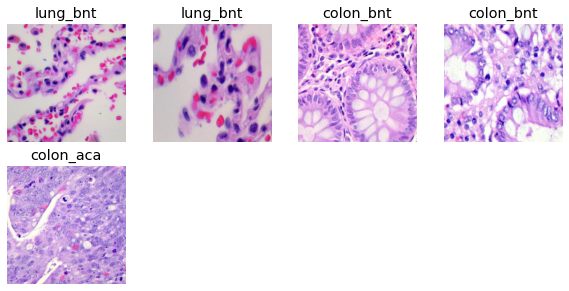

In [14]:
className = 'Dataset'
cpath = os.path.join(mpath, 'Dataset')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)


In [ ]:
batch_size = [16,32]
dropout = [0.3,0.5]

16705208/16705208 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)     

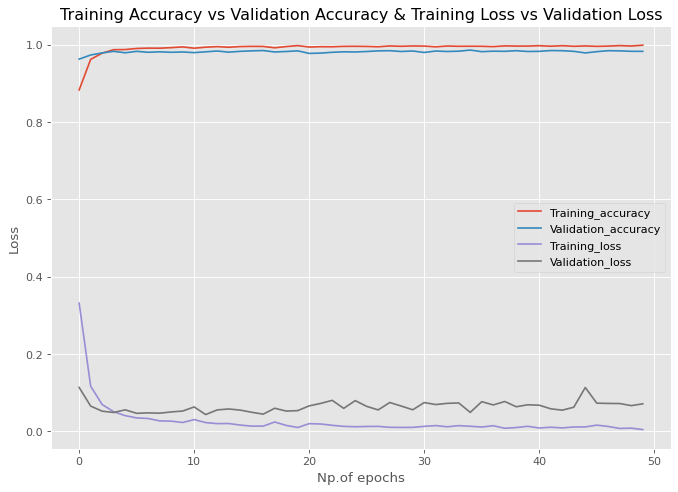

76/76 [==============================] - 19s 243ms/step - loss: 0.0712 - accuracy: 0.9827
Accuracy on the Test Set = 98.27 %
True :  [0 0 0 ... 4 4 4]
76/76 [==============================] - 21s 239ms/step
Predicted :  [0 0 0 ... 4 4 4]


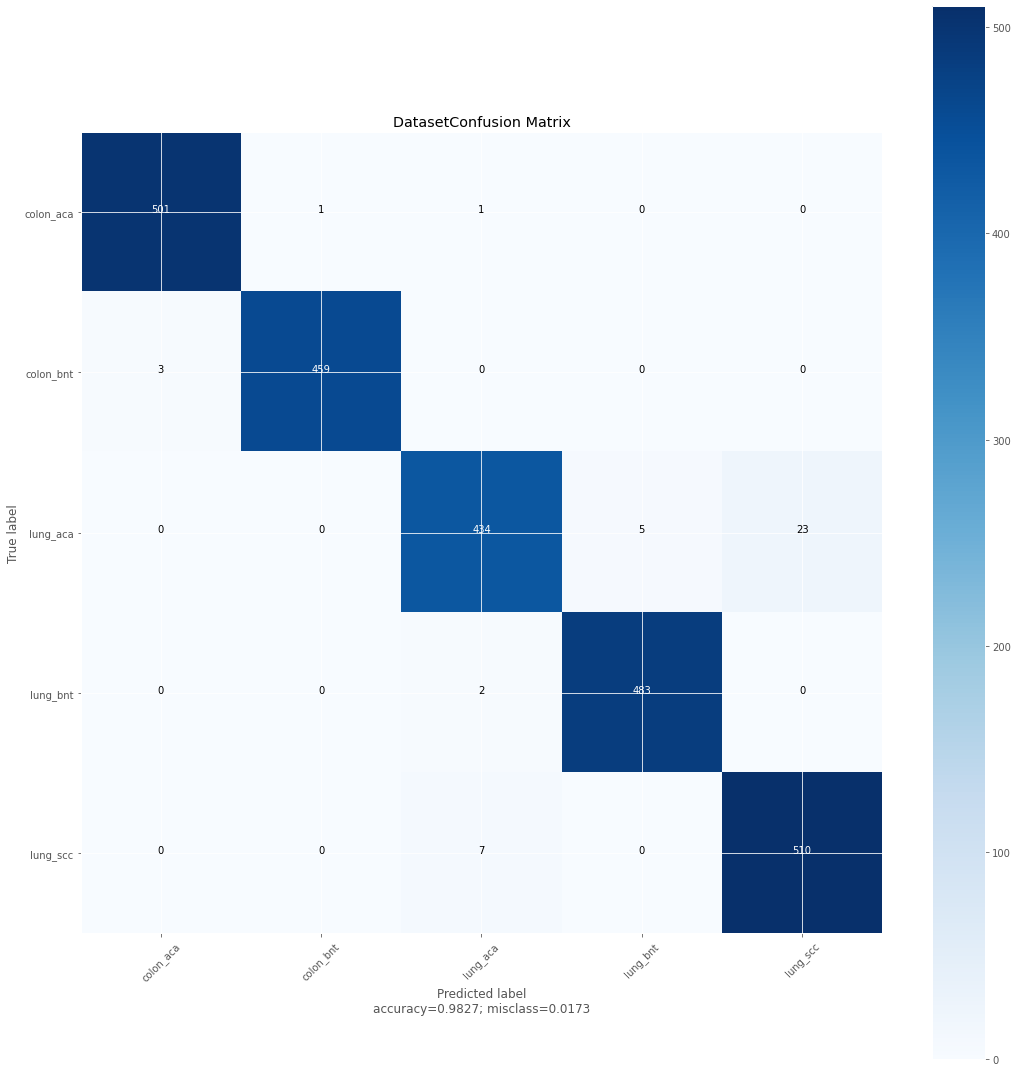

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
for i in range(2):
  for j in range(2):
    curModel = initiateModel(noOfClasses,dropout[j])
    modelSummary(curModel)
    curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
    curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=batch_size[i])
    plotOutput(curHistory, className, gEpochs)
    evalModel(curModel)
    # saveModel(curModel, className)
    callPlot(curModel, className, class_names)

SKIP
16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)

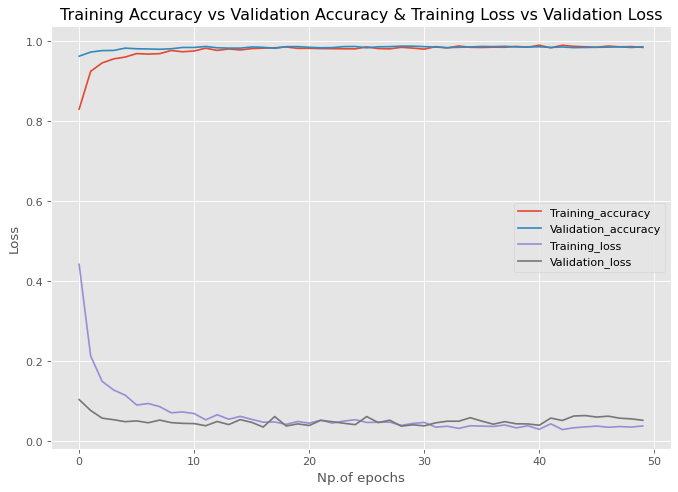

76/76 [==============================] - 19s 245ms/step - loss: 0.0527 - accuracy: 0.9856
Accuracy on the Test Set = 98.56 %
True :  [0 0 0 ... 4 4 4]
76/76 [==============================] - 19s 228ms/step
Predicted :  [0 0 0 ... 4 2 4]


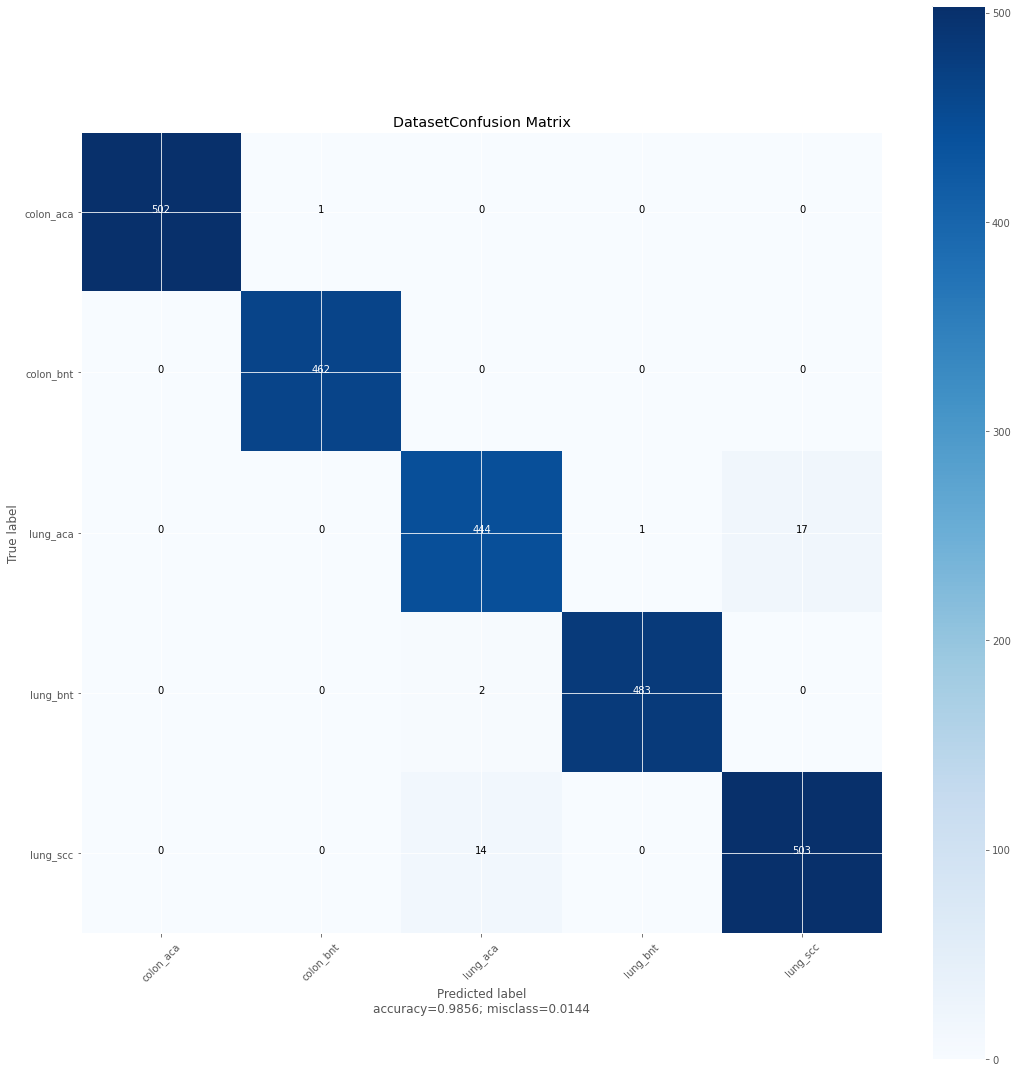

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
for i in range(2):
  for j in range(2):
    if i==0 and j==0:
      print("SKIP")
    else:
      curModel = initiateModel(noOfClasses,dropout[j])
      modelSummary(curModel)
      curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
      curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=batch_size[i])
      plotOutput(curHistory, className, gEpochs)
      evalModel(curModel)
      # saveModel(curModel, className)
      callPlot(curModel, className, class_names)

In [ ]:
batch_size = [32]
dropout = [0.3,0.5]

16705208/16705208 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)     

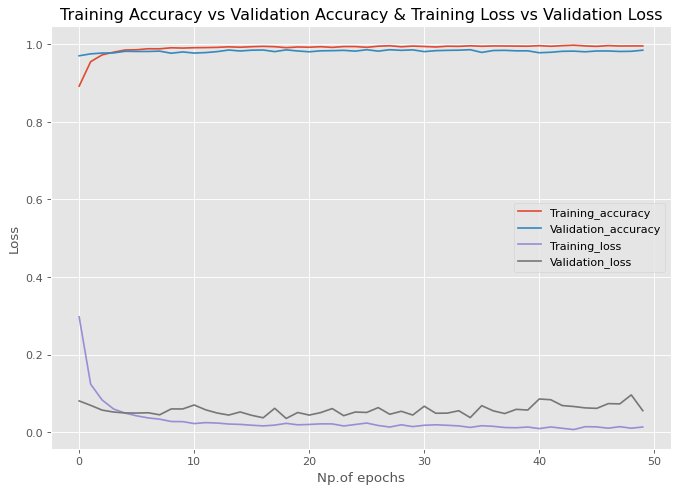

76/76 [==============================] - 19s 248ms/step - loss: 0.0551 - accuracy: 0.9852
Accuracy on the Test Set = 98.52 %
True :  [0 0 0 ... 4 4 4]
76/76 [==============================] - 19s 232ms/step
Predicted :  [0 0 0 ... 4 4 4]


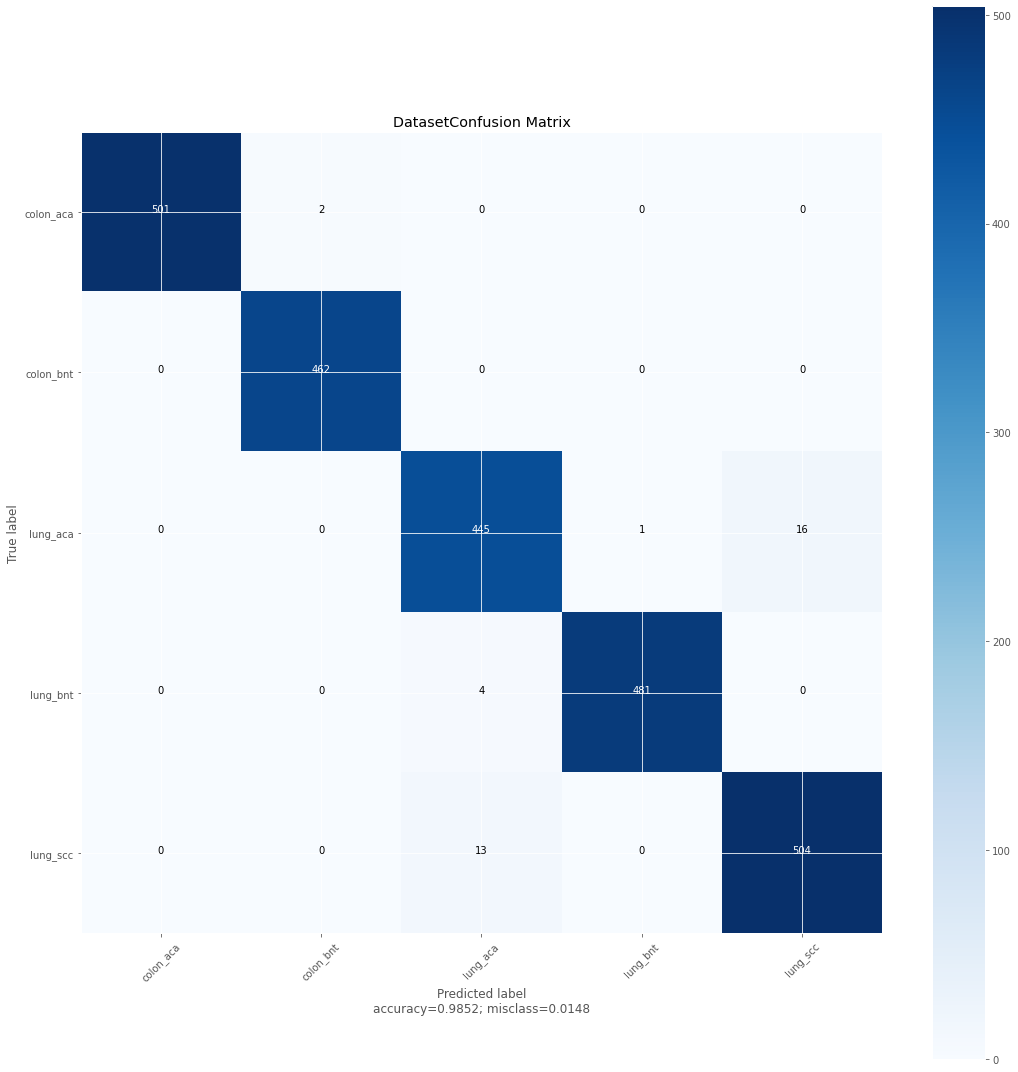

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
for i in range(1):
  for j in range(2):
    curModel = initiateModel(noOfClasses,dropout[j])
    modelSummary(curModel)
    curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
    curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=batch_size[i])
    plotOutput(curHistory, className, gEpochs)
    evalModel(curModel)
    # saveModel(curModel, className)
    callPlot(curModel, className, class_names)

In [15]:
batch_size = [32]
dropout = [0.5]

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)     

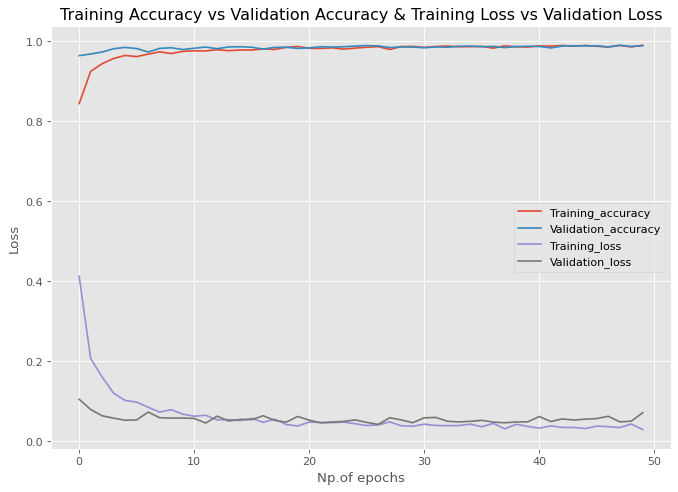

76/76 [==============================] - 17s 225ms/step - loss: 0.0703 - accuracy: 0.9876
Accuracy on the Test Set = 98.76 %
True :  [0 0 0 ... 4 4 4]
76/76 [==============================] - 18s 221ms/step
Predicted :  [0 0 0 ... 4 4 4]


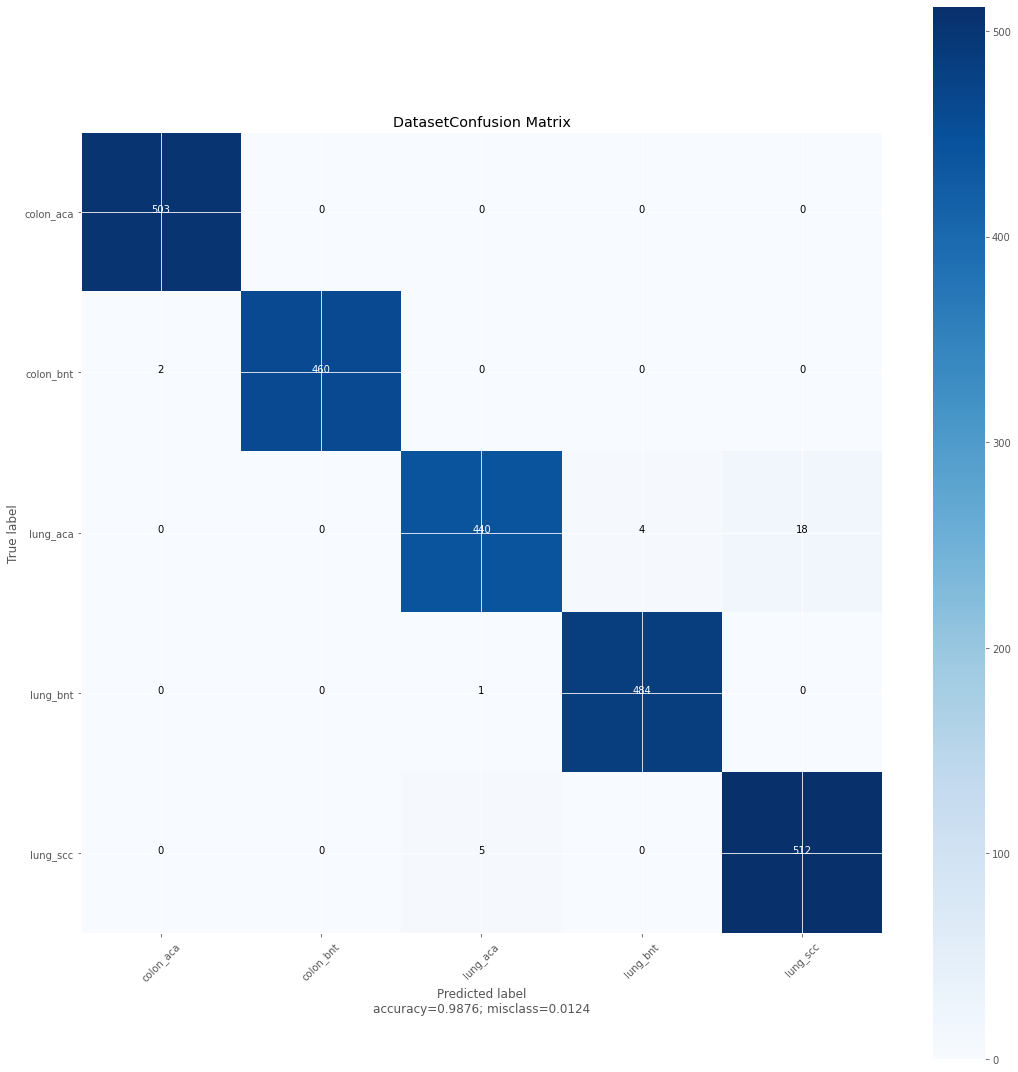

<Figure size 432x288 with 0 Axes>

In [16]:
for i in range(1):
  for j in range(1):
    curModel = initiateModel(noOfClasses,dropout[j])
    modelSummary(curModel)
    curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
    curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=batch_size[i])
    plotOutput(curHistory, className, gEpochs)
    evalModel(curModel)
    # saveModel(curModel, className)
    callPlot(curModel, className, class_names)